In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
all_w = np.load('100317_bolplanck_smaller_step_Fisher.npz')

In [3]:
all_w.files

['wp_cov', 'wprp', 'ngals', 'param']

In [4]:
param = all_w['param']
wp = all_w['wprp']
wpcov = all_w['wp_cov']
param_median = np.median(param,axis=0)
param_median

array([  1.02654941,  13.1879107 ,   0.87818971,  12.10313919,
        12.26929428,   0.91596941,   0.02586083])

In [5]:
param[::200]-param_median

array([[-0.025,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.02 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.015,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.01 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.005,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.005,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.01 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.015,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.025,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.025,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.02 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.015,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.01 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.005,  

In [6]:
r_wp = np.logspace(-1, 1.4, 20)
r_wp = (r_wp[:-1]+r_wp[1:])/2.
r_wp

array([  0.11687839,   0.15633276,   0.20910566,   0.27969299,
         0.37410832,   0.50039523,   0.66931252,   0.89525084,
         1.19745866,   1.60168208,   2.1423583 ,   2.86554937,
         3.83286643,   5.12671854,   6.85733338,   9.172148  ,
        12.26836937,  16.40977524,  21.94918617])

In [7]:
mask_median = np.logical_and(param.T[0]==param_median[0],param.T[1]==param_median[1])
for i in range(5):
    mask_median = np.logical_and(mask_median,param.T[i+2]==param_median[i+2])

In [8]:
pstep = np.array((0.005,0.005,0.005,0.005,0.005,0.005,0.005))

In [9]:
def mask(i,dpi):
    mask = param.T[i]==param_median[i]+dpi*pstep[i]
    return mask

In [10]:
covar_real = np.cov(wp[mask_median].T)

In [11]:
covar_cosmic = np.mean(wpcov[mask_median],axis=0)

In [12]:
covar_tot = covar_cosmic+covar_real

In [13]:
def Fisher(i,j,dpi,dpj,func=wp,covar=covar_tot):
    d_func_i = np.mean(func[mask_median],axis=0)-np.mean(func[mask(i,dpi)],axis=0)
    d_func_j = np.mean(func[mask_median],axis=0)-np.mean(func[mask(j,dpj)],axis=0)
    I_ij = np.dot(d_func_i,np.dot(np.linalg.inv(covar),d_func_j))/(dpi*dpj*pstep[i]*pstep[j])
    return I_ij

In [14]:
Fisher_element_list = np.zeros((7,7,10,10))  ##0:-5,1:-4,2:-3,3:-2,4:-1,5:1,6:2,7:3,8:4,9:5

In [15]:
def dp(x):   ##index to dp
    if x<5:
        return x-5
    else:
        return x-4

In [16]:
def invdp(x):   ##dp to index
    if x<0:
        return x+5
    if x>0:
        return x+4

In [17]:
for i in range(7):
    for j in range(7):
        for di in range(10):
            for dj in range(10):
                Fisher_element_list[i,j,di,dj] = Fisher(i,j,dp(di),dp(dj))

In [18]:
def Fmatrix(d_vector):
    fmatrix = np.zeros((7,7))
    for i in range(7):
        for j in range(7):
            fmatrix[i,j] = Fisher_element_list[i,j,int(invdp(d_vector[i])),int(invdp(d_vector[j]))]
    return fmatrix

In [19]:
np.sqrt(np.linalg.inv(Fmatrix([1,1,1,1,1,1,1])).diagonal())

array([ 0.02922576,  0.03702284,  0.03338267,  0.05845931,  0.02541005,
        0.03358237,  0.05338767])

In [20]:
color=plt.cm.rainbow(np.linspace(0,1,5))

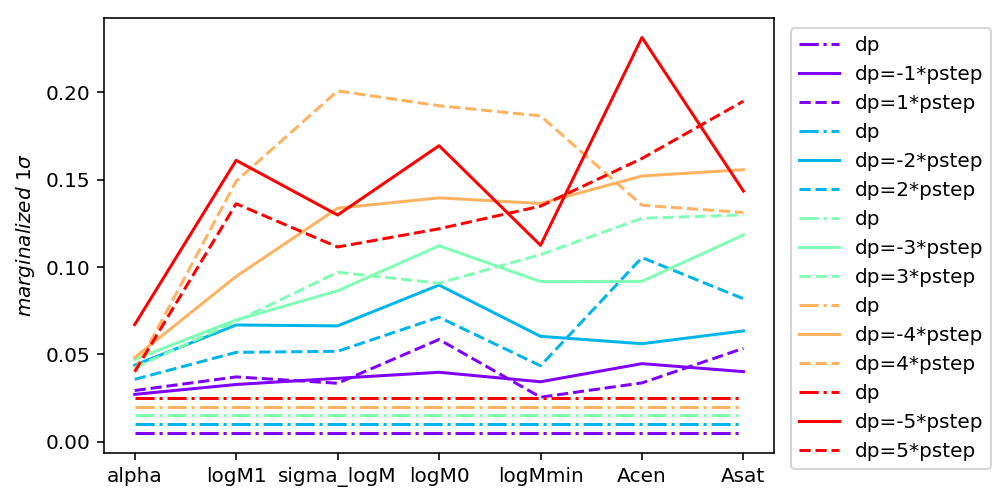

In [29]:
for i in range(1,6):
    plt.plot(range(7),i*pstep,'-.',color=color[i-1],label='dp')
    plt.plot(range(7),np.sqrt(np.linalg.inv(Fmatrix((-i)*np.ones(7))).diagonal()),color=color[i-1],label='dp={}*pstep'.format(-i))
    plt.plot(range(7),np.sqrt(np.linalg.inv(Fmatrix((i)*np.ones(7))).diagonal()),'--',color=color[i-1],label='dp={}*pstep'.format(i))
plt.xticks((0,1,2,3,4,5,6),('alpha','logM1','sigma_logM','logM0','logMmin','Acen','Asat'))
plt.legend(bbox_to_anchor=(1.01, 1))
plt.ylabel(r'$marginalized\ 1 \sigma$')

In [22]:
(Fisher_element_list[0,0,:,:].diagonal())**(-0.5)

array([ 0.014628  ,  0.01415202,  0.01408333,  0.01251582,  0.01284588,
        0.01183397,  0.01370232,  0.01278888,  0.01255259,  0.01255095])

In [23]:
(Fisher_element_list[1,1,:,:].diagonal())**(-0.5)

array([ 0.01153314,  0.01160706,  0.01198354,  0.01277706,  0.01143579,
        0.01061973,  0.01239306,  0.01225652,  0.01285016,  0.01243689])

In [24]:
(Fisher_element_list[2,2,:,:].diagonal())**(-0.5)

array([ 0.01383736,  0.0142916 ,  0.01319508,  0.0132611 ,  0.0100952 ,
        0.01258104,  0.01466625,  0.01421263,  0.01415496,  0.01450031])

In [25]:
(Fisher_element_list[3,3,:,:].diagonal())**(-0.5)

array([ 0.0934625 ,  0.09376257,  0.0772764 ,  0.05851523,  0.03056675,
        0.03570743,  0.0622459 ,  0.06780902,  0.12114086,  0.10973956])

In [26]:
(Fisher_element_list[4,4,:,:].diagonal())**(-0.5)

array([ 0.0120069 ,  0.01210385,  0.01147011,  0.01137594,  0.01162285,
        0.00971868,  0.01093757,  0.0110032 ,  0.01138885,  0.01071834])

In [27]:
(Fisher_element_list[5,5,:,:].diagonal())**(-0.5)

array([ 0.15871971,  0.12075528,  0.06695282,  0.0428798 ,  0.03312941,
        0.02602202,  0.07898997,  0.08581445,  0.10577767,  0.13164854])

In [28]:
(Fisher_element_list[6,6,:,:].diagonal())**(-0.5)

array([ 0.10764688,  0.1083378 ,  0.08472409,  0.05791845,  0.032244  ,
        0.03499559,  0.07548764,  0.05618894,  0.05825661,  0.09229053])